# Extracting Semantic Information from Product Titles with MXNet, and Gluon

1. [Introduction](#Introduction)
2. [Preprocessing](#Preprocessing)   
3. [Use Pretrained Model](#Use-Pretrained-Model)
4. [Model Evaluation](#Model-Evaluation)

## Introduction


In the recent past, there has been tremendous amount of research on recommender systems. In particular, Deep Structured Semantic models attempt to capture information from attributes, such as product image, title and description. Extracting semantic information from these additional characteristics will solve the "cold start" problem in the space of recommender systems. In other words, when there is no much consumption history for a given user, a recommender system can propose products similar to the minimal products purchased by the user.

In this section, we will focus on how pre-trained word embeddings can be used in SageMaker to find books similar to the books that a user likes.

We will look at book ratings dataset, goodbooks-10k. The dataset consists of 6 million ratings from 53,242 users on 10,000 books. More details on this dataset can be found [here](https://www.kaggle.com/zygmunt/goodbooks-10k).
We take a subset of this dataset to illustrate the concept of Bringing Your Own Model to SageMaker.

We are using conda mxnet p36 kernel

#### License

The goodbooks-10k dataset is licensed under the Creative Commons Attribution-ShareAlike 4.0 International License. 
To view a copy of this license, visit http://creativecommons.org/licenses/by-sa/4.0/.

In [2]:
#!pip freeze | grep onnx
!pip uninstall onnx --yes
!pip install --upgrade onnx==1.1.1

Uninstalling onnx-1.2.1:
  Successfully uninstalled onnx-1.2.1
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 942kB 23.8MB/s ta 0:00:01
Requirement not upgraded as not directly required: six in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from onnx==1.1.1) (1.11.0)
Requirement not upgraded as not directly required: protobuf in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from onnx==1.1.1) (3.5.2)
Requirement not upgraded as not directly required: numpy in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from onnx==1.1.1) (1.14.5)
Requirement not upgraded as not directly required: setuptools in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from protobuf->onnx==1.1.1) (39.1.0)
  Running setup.py bdist_wheel for onnx ... done
  Stored in directory: /home/ec2-

In [3]:
!pip install --upgrade pip
!pip install mxnet-mkl 
!pip install --disable-pip-version-check  gluonnlp
!pip install nltk

  Using cached https://files.pythonhosted.org/packages/30/db/9e38760b32e3e7f40cce46dd5fb107b8c73840df38f0046d8e6514e675a1/pip-19.2.3-py2.py3-none-any.whl
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
     |████████████████████████████████| 245kB 28.6MB/s eta 0:00:01
  Created wheel for gluonnlp: filename=gluonnlp-0.8.1-cp36-none-any.whl size=289393 sha256=97439f538bcdcdb40b8248d2bbe632fbf7bedff63006bf51fde3af0e356b8933
  Stored in directory: /home/ec2-user/.cache/pip/wheels/3e/e7/3e/9cdf8ad7fce112fde2f4a52604045e5dd80f84d645bedb70c7
Successfully built gluonnlp


In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
#Import necessary modules
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray
from mxnet.metric import MSE
import pandas as pd
import numpy as np
import sagemaker
from sagemaker.mxnet import MXNet
import boto3
import json
import matplotlib.pyplot as plt
import gluonnlp as nlp
import itertools
from nltk.tokenize import word_tokenize
import nltk
from sklearn.manifold import TSNE

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

## Preprocessing
Read book titles and generate words from the same, removing punctuation marks and numbers

### Read the book ratings dataset

In [7]:
fn = 'ClndBookRatings.csv'
#print(os.path.isfile(fn))

df_bkRatngs = pd.read_csv(fn, index_col=None)
df_bkRatngs.tail()

,book_id,user_id,rating,title,book_ind,user_ind
1051294,699,26182,3,Twenty Thousand Leagues Under the Sea,740,4637
1051295,699,33073,3,Twenty Thousand Leagues Under the Sea,740,6388
1051296,699,33298,3,Twenty Thousand Leagues Under the Sea,740,6432
1051297,699,48174,3,Twenty Thousand Leagues Under the Sea,740,9812
1051298,699,51778,4,Twenty Thousand Leagues Under the Sea,740,10575


In [9]:
df_bkRatngs.shape

(1051299, 6)

The dataset includes information like:

- `book_id`: Unique identifier of a book
- `user_id`: Unique identifier of a user rating the book
- `rating`: Rating of the book.
- `title`: Title of the book

In [8]:
df_bktitles = pd.DataFrame(df_bkRatngs['title'].unique(), columns=['BookTitle'])


In [13]:
df_bktitles.head()

,BookTitle
0,Stones from the River
1,The Very Hungry Caterpillar Board Book
2,The Brief Wondrous Life of Oscar Wao
3,Firestarter
4,On Writing: A Memoir of the Craft


### Prepare words list from book titles

In [9]:
# get words from each title, remove words with punctuation marks, numbers, and lower case words

words = []

for i in df_bktitles['BookTitle']:
    tokens = word_tokenize(i)
    #print(tokens)
    # remove all tokens that are not alphabetic
    words.append([word.lower() for word in tokens if word.isalpha()])   # - this is list of lists

    
#remove empty strings from words list
words = list(filter(None, words))

In [10]:
len(words)
#words is a list of lists
#print(words)
#print(words[0])

978

## Use Pretrained Model

Get word embedding from pre-trained fastText model. fastText is a library for learning of word embeddings and text classification created by Facebooks's AI Research Lab

In [11]:
#counter = nlp.data.count_tokens(itertools.chain.from_iterable([i.split() for i in reduced_df['product_title'].unique()]))

# vocab is a dictionary of key value pairs (value is number of times a word appears in the entire list of titles)
counter = nlp.data.count_tokens(itertools.chain.from_iterable(words))
vocab = nlp.Vocab(counter)

In [12]:
# Get the pretrained embeddings for each of the words
fasttext_simple = nlp.embedding.create('fasttext', source='wiki.simple')
vocab.set_embedding(fasttext_simple)

Embedding file wiki.simple.npz is not found. Downloading from Gluon Repository. This may take some time.


## Model Evaluation
Let us create title embedding and assess semantic similarity of different titles

### Create embedding of a book title by averaging across individual word embeddings 

Start by instantiating an empty ndarray (multi dimensional)

In [13]:
title_arr_list = np.empty((0,300), dtype='f')

To create title embedding, average across individual word embeddings for each of the words in the title

In [14]:
for title in words:
    #print(title)
    #print(vocab.embedding[title])
    title_arr = ndarray.mean(vocab.embedding[title], axis=0, keepdims=True)
    #print(title_arr)
    title_arr_list = np.append(title_arr_list, title_arr.asnumpy(), axis=0)

In [20]:
title_arr_list.shape

(978, 300)

In [21]:
title_arr_list[532]

array([ 1.93852320e-01,  1.79058332e-02,  2.13679988e-02, -1.29750535e-01,
        1.92136168e-01,  1.96600005e-01, -1.14082493e-01, -1.08130991e-01,
        1.50110656e-02,  1.30268605e-02,  9.92920026e-02,  1.03956997e-01,
        1.54266655e-02,  1.40365839e-01, -1.76157236e-01,  5.72251678e-02,
       -1.04448326e-01,  8.53966698e-02, -8.22504386e-02, -5.64893372e-02,
        6.23830073e-02,  2.53173679e-01, -1.76820502e-01, -1.01686664e-01,
       -9.91069302e-02, -1.31027326e-01,  8.75925347e-02, -1.89199373e-01,
        1.04083337e-01,  1.15040004e-01,  7.06133321e-02,  5.24753332e-02,
        1.07963337e-02,  1.32992432e-01, -5.44673465e-02, -9.84523296e-02,
       -3.14673334e-02,  1.33178666e-01, -1.47596672e-01, -1.59549996e-01,
        2.94593330e-02,  1.10433251e-03,  1.18282832e-01, -1.33879840e-01,
        2.86506504e-01,  4.49625365e-02, -4.22555022e-02,  1.63066632e-03,
        2.54259676e-01,  6.11909963e-02,  3.93520035e-02, -2.14153662e-01,
       -1.30343005e-01,  

In [22]:
words[532]

['the', 'waste', 'lands', 'the', 'dark', 'tower']

Determine if there are any titles that do not have a numerical representation

In [24]:
np.isnan(title_arr_list).any()
#title_arr_list[np.isnan(title_arr_list)].shape
#arr1, arr2 = np.where(np.isnan(title_arr_list))

#pd.DataFrame(arr1).to_csv('rownan.csv')

False

### Plot book title embeddings to locate similar books

T-distributed stochastic neighborhood embedding (t-SNE) is a machine learning algorithm for visualization. It is a non-linear dimensionality reduction technique

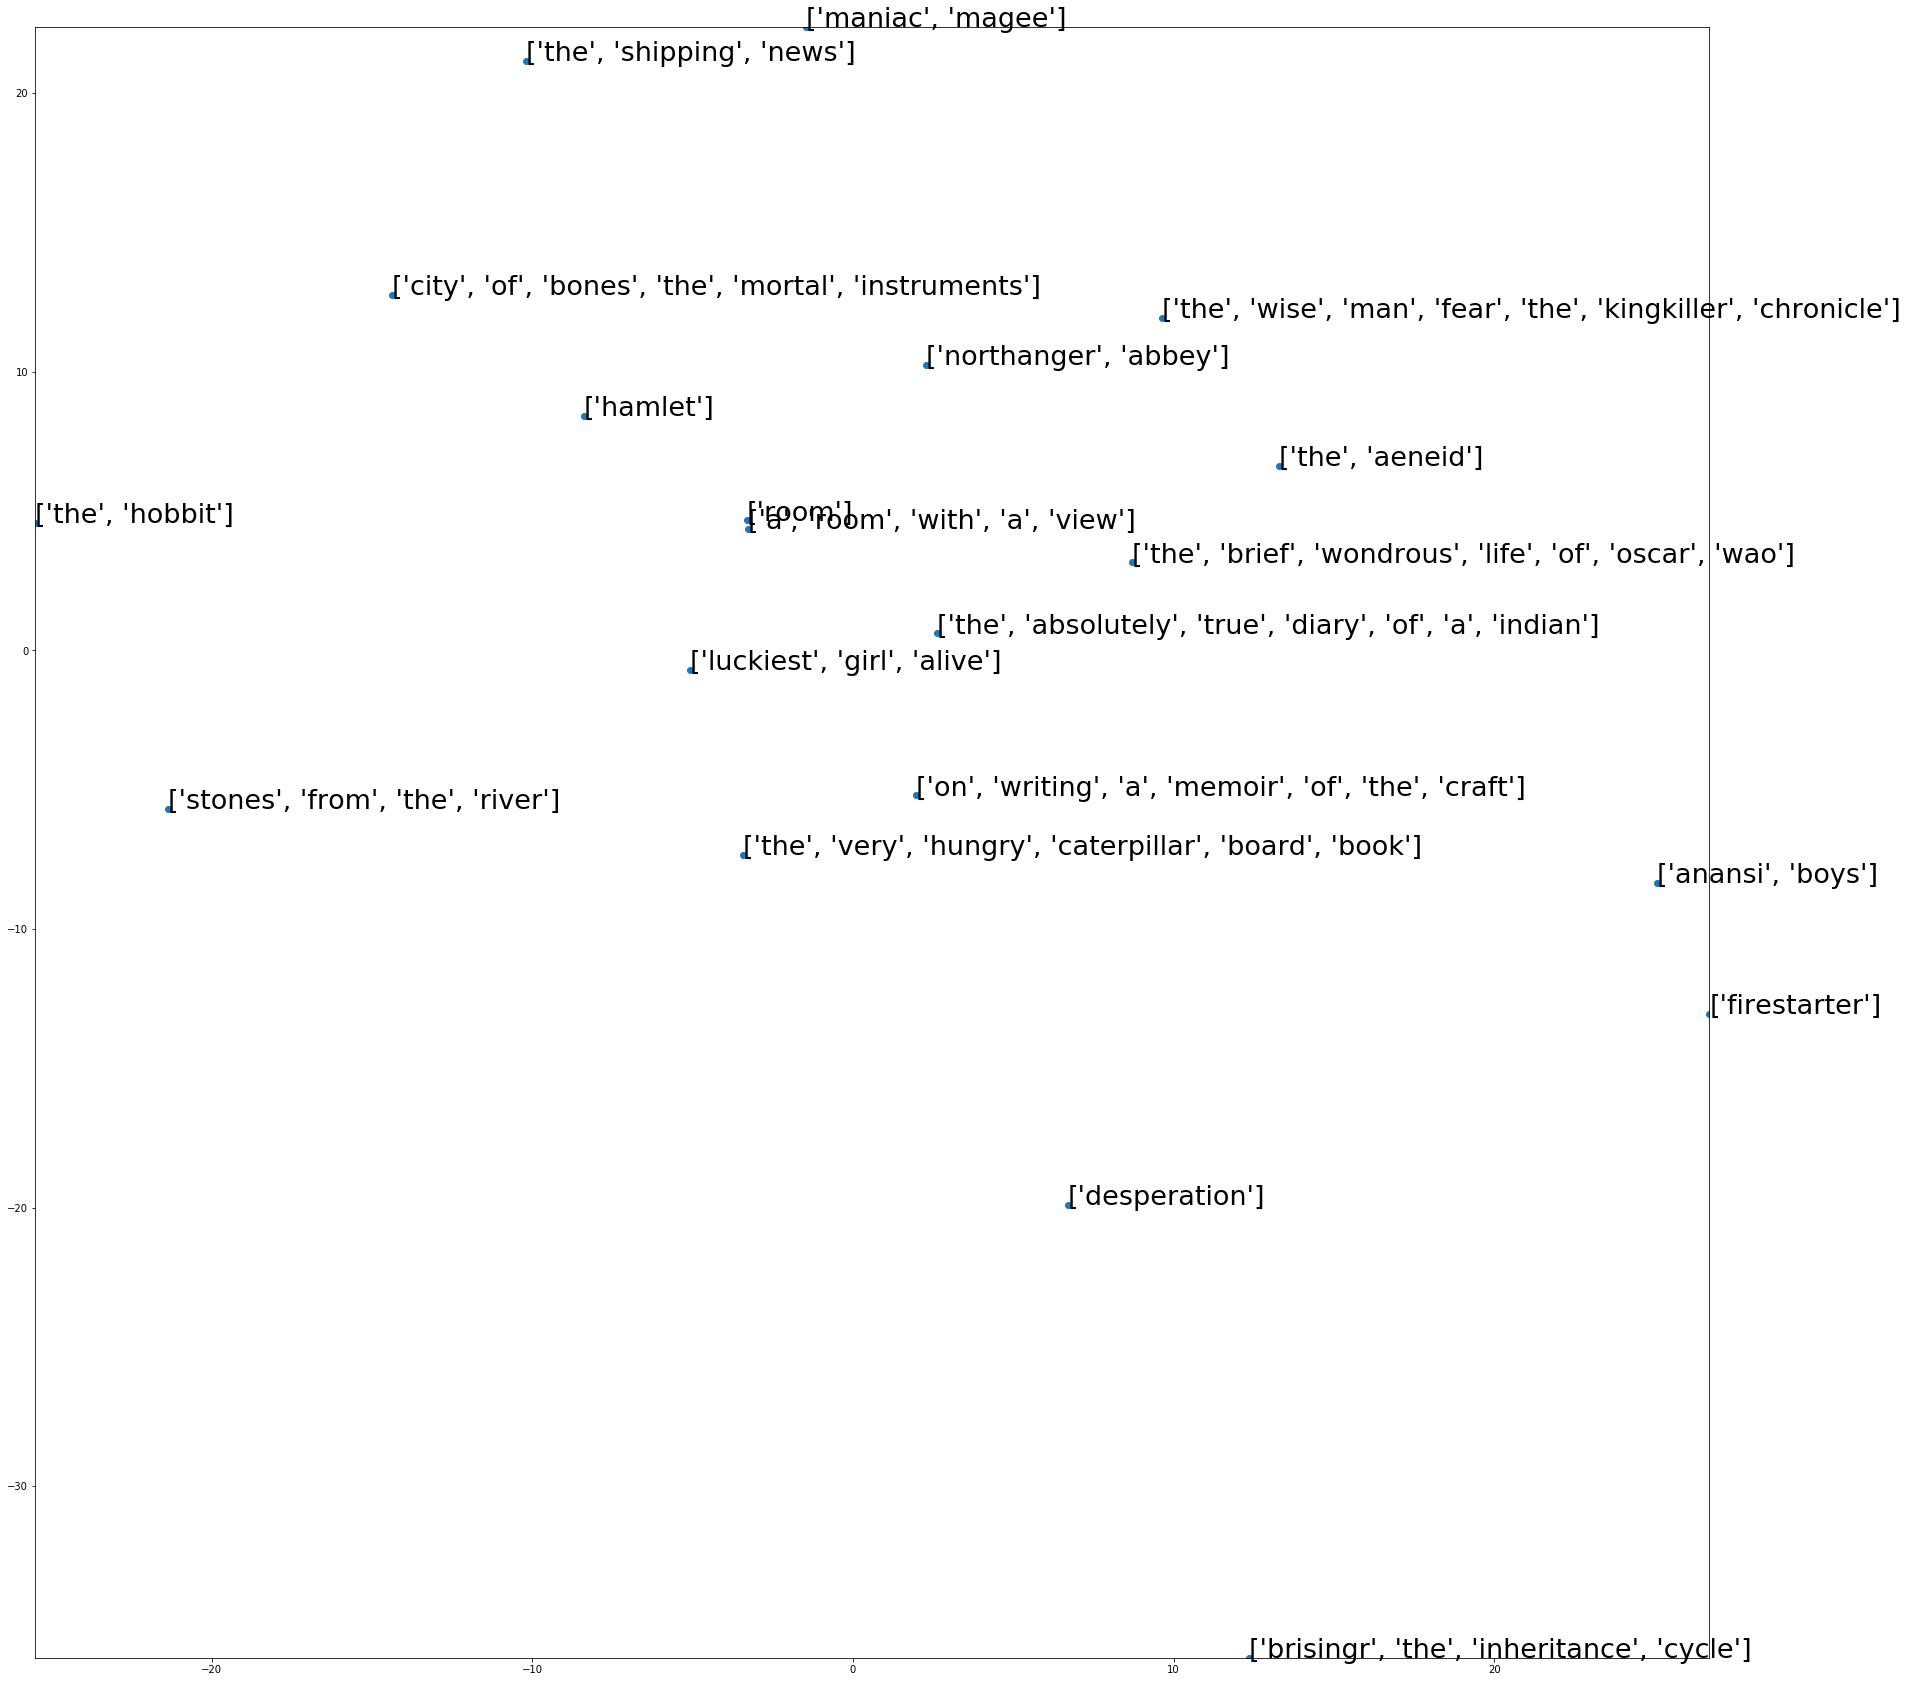

In [18]:
#show tsne plot

#word_labels = [words]

 # find tsne coords for 2 dimensions
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(title_arr_list)

#select first 20 titles
word_labels = words[0:20]

x_coords = Y[0:20, 0]
y_coords = Y[0:20, 1]

# display scatter plot
plt.figure(figsize=(30, 30))
plt.scatter(x_coords, y_coords)

for label, x, y in zip(word_labels, x_coords, y_coords):
    #print("label x y", label, x, y)
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', size=27, wrap=True)
    #clip_on=True

plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()